In [14]:
import pandas as pd
import seaborn as sbn
import geopandas as geo_pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import sqlite3
import os

## Load Unit Data

In [2]:
data_dir_prefix = '../../../../data/'
database_path = data_dir_prefix + 'fire_data_v2.db'

In [3]:
# query the unit response data for 2019
with sqlite3.connect(database_path) as db_conn:
    # get unit response data
    q = """
        SELECT 
            call_number, incident_number, call_type, call_type_group, 
            unit_id, unit_type, 
            call_date, received_dttm, dispatch_dttm, on_scene_dttm,
            `neighborhooods_-_analysis_boundaries`, case_location
        FROM calls_for_service 
        WHERE cast(strftime('%Y', received_dttm) as int) = 2019 
            AND unit_sequence_in_call_dispatch <= 5"""
    unit_response_data_raw = pd.read_sql_query(q, db_conn)

    # get facility data
    fire_station_data_raw = pd.read_sql_query("select * from fire_stations", db_conn)


print(unit_response_data_raw.dtypes)

print(fire_station_data_raw.dtypes)

call_number                              int64
incident_number                          int64
call_type                               object
call_type_group                         object
unit_id                                 object
unit_type                               object
call_date                               object
received_dttm                           object
dispatch_dttm                           object
on_scene_dttm                           object
neighborhooods_-_analysis_boundaries    object
case_location                           object
dtype: object
index                         int64
facility_id                   int64
common_name                  object
address                      object
city                         object
zip_code                      int64
block_lot                    object
owned_leased                 object
dept_id_for_jurisdiction      int64
jurisdiction                 object
gross_sq_ft                 float64
longitude                 

In [4]:
# convert dataframe to geodataframe
unit_response_data = geo_pd.GeoDataFrame(unit_response_data_raw)
unit_response_data['pt_case_location'] = geo_pd.GeoSeries.from_wkt(
    unit_response_data_raw['case_location'],
    crs='EPSG:4326')

unit_response_data = geo_pd.GeoDataFrame(unit_response_data, 
    geometry='pt_case_location')

unit_response_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 305923 entries, 0 to 305922
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   call_number                           305923 non-null  int64   
 1   incident_number                       305923 non-null  int64   
 2   call_type                             305923 non-null  object  
 3   call_type_group                       304040 non-null  object  
 4   unit_id                               305923 non-null  object  
 5   unit_type                             305923 non-null  object  
 6   call_date                             305923 non-null  object  
 7   received_dttm                         305923 non-null  object  
 8   dispatch_dttm                         305923 non-null  object  
 9   on_scene_dttm                         254063 non-null  object  
 10  neighborhooods_-_analysis_boundaries  305923 non

In [5]:
fire_stations = fire_station_data_raw.copy()
fire_stations['point'] = geo_pd.points_from_xy(fire_station_data_raw.longitude, fire_station_data_raw.latitude, crs="EPSG:4326")
fire_stations = geo_pd.GeoDataFrame(fire_stations, geometry='point')
fire_stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

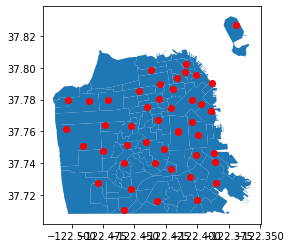

In [6]:
# grab the SF neighborhood map, plot the fire stations

plt.rcParams["figure.figsize"]=15,15

sf_neighborhoods = geo_pd.read_file(data_dir_prefix+'raw/SF Find Neighborhoods.geojson')
base_map = sf_neighborhoods.geometry.plot()

_ = fire_stations.plot(color="red", ax=base_map, edgecolor="black", color="white")

## Create Map Grid (Quadrats)

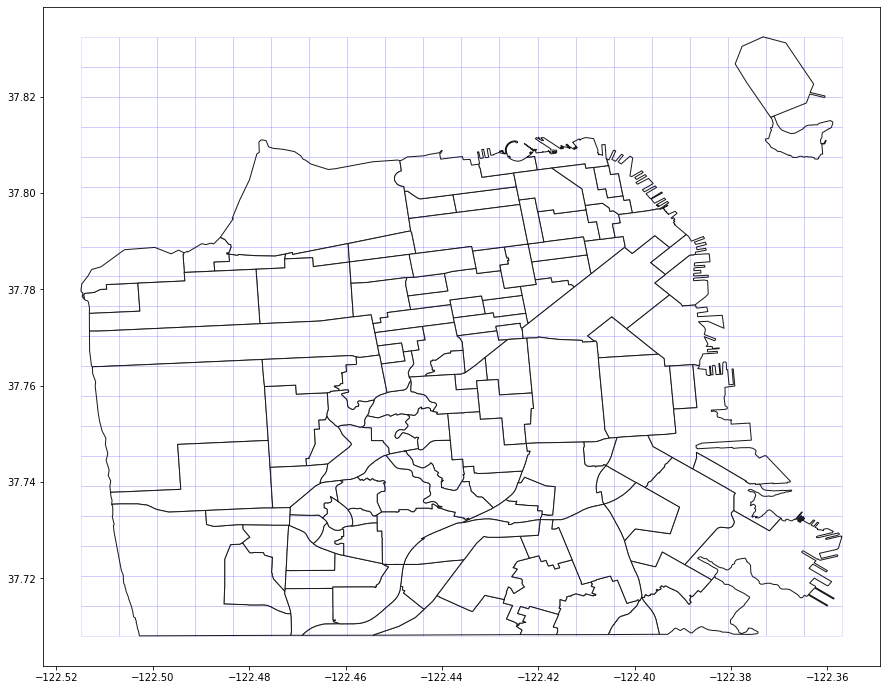

In [7]:
# create quadrat grid

from shapely.geometry import Polygon

# get dimensions of current region
xmin, ymin, xmax, ymax = sf_neighborhoods.geometry.total_bounds
step_size = 20
step_x = (xmax - xmin) / step_size
step_y = (ymax - ymin) / step_size

# create a single column of x and y, to later cross product
x_left = np.arange(xmin, xmax, step_x)
x_df = pd.DataFrame(np.column_stack((x_left,x_left + step_x)), columns=['x_left', 'x_right'])
y_top = np.arange(ymax, ymin, -step_y)
y_df = pd.DataFrame(np.column_stack((y_top, y_top - step_y)), columns=['y_top', 'y_bottom'])

# cross product dummy cols
x_df['dummy'] = 1
y_df['dummy'] = 1

# cross-product to get the grid polygons
grid_polygons = x_df.merge(y_df, on='dummy', how='inner').drop("dummy", axis=1)
grid_polygons

# plot the quadrats
plt.rcParams["figure.figsize"]=15,15
grid_poly = geo_pd.GeoSeries(grid_polygons.apply(lambda d: Polygon([    
    (d.x_left, d.y_top),    
    (d.x_left, d.y_bottom),
    (d.x_right, d.y_bottom),
    (d.x_right, d.y_top)]), axis = 1))

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = grid_poly.plot(ax = full_plot, color="white", edgecolor="blue", alpha=0.33)

In [8]:
grid_polygons

,x_left,x_right,y_top,y_bottom
0,-122.514897,-122.507001,37.832396,37.826181
1,-122.514897,-122.507001,37.826181,37.819965
2,-122.514897,-122.507001,37.819965,37.813750
3,-122.514897,-122.507001,37.813750,37.807535
4,-122.514897,-122.507001,37.807535,37.801319
...,...,...,...,...
395,-122.364878,-122.356982,37.739166,37.732951
396,-122.364878,-122.356982,37.732951,37.726735
397,-122.364878,-122.356982,37.726735,37.720520
398,-122.364878,-122.356982,37.720520,37.714305


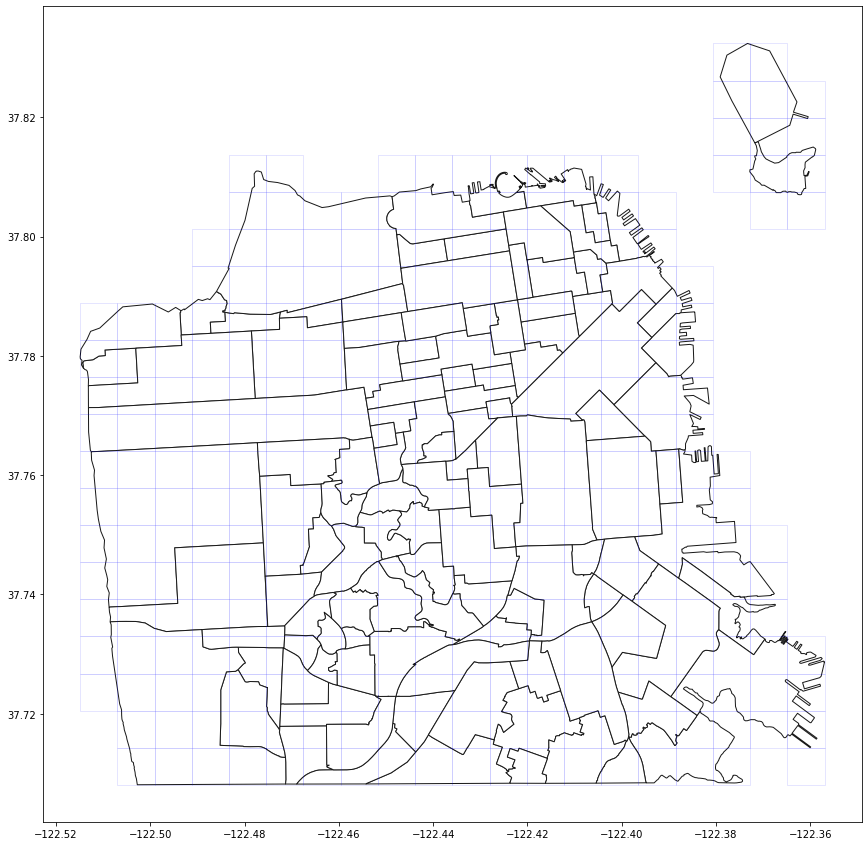

In [9]:

grid_zones = grid_poly.to_frame("zone").reset_index().rename({"index": "zone_idx"}, axis=1)
grid_zones = geo_pd.GeoDataFrame(grid_zones, crs="EPSG:4326", geometry='zone')
grid_zones = geo_pd.sjoin(grid_zones, sf_neighborhoods, how='inner', op='intersects')[['zone_idx', 'zone']]
grid_zones = grid_zones.drop_duplicates()

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = grid_zones.plot(ax = full_plot, color="white", edgecolor="blue", alpha=0.33)

In [10]:
grid_zones['centroid'] = grid_zones.geometry.centroid
grid_zones.to_csv(data_dir_prefix + "/raw/zone_grid.csv")

/tmp/ipykernel_8506/4250326246.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_zones['centroid'] = grid_zones.geometry.centroid


## Calculate Catchments for each Unit

In [11]:
# see if unit responses typically fit into a handful of neighborhoods
pd.set_option('display.max_rows', 30)

unit_response_data['unit_desc'] = unit_response_data.unit_type + ' - ' + unit_response_data.unit_id
unit_response_summary = unit_response_data.groupby(['unit_desc', 'neighborhooods_-_analysis_boundaries'])\
    .agg({'incident_number':'count'}).unstack(fill_value=0.0)

unit_response_summary.to_csv(data_dir_prefix+'raw/unit_response_summary.csv')

unit_response_summary

incident_number                 \
neighborhooods_-_analysis_boundaries Bayview Hunters Point Bernal Heights   
unit_desc                                                                   
AIRPORT - AP                                           0.0            0.0   
CHIEF - B01                                            3.0            0.0   
CHIEF - B02                                            4.0            3.0   
CHIEF - B03                                           22.0           11.0   
CHIEF - B04                                            0.0            0.0   
...                                                    ...            ...   
TRUCK - T16                                            0.0            0.0   
TRUCK - T17                                          961.0            6.0   
TRUCK - T18                                            1.0            0.0   
TRUCK - T19                                            0.0            0.0   
TRUCK - T48                                            1.0            0.0   

                                                                              \
neighborhooods_-_analysis_boundaries Castro/Upper Market Chinatown Excelsior   
unit_desc                                                                      
AIRPORT - AP                                         0.0       0.0       0.0   
CHIEF - B01                                          0.0     370.0       0.0   
CHIEF - B02                                        151.0       1.0       0.0   
CHIEF - B03                                          0.0      23.0       0.0   
CHIEF - B04                                          1.0      22.0       0.0   
...                                                  ...       ...       ...   
TRUCK - T16                                          0.0       0.0       0.0   
TRUCK - T17                                          0.0       0.0       0.0   
TRUCK - T18                                          0.0       0.0       0.0   
TRUCK - T19                                          0.0       0.0       7.0   
TRUCK - T48                                          0.0       0.0       0.0   

                                                                               \
neighborhooods_-_analysis_boundaries Financial District/South Beach Glen Park   
unit_desc                                                                       
AIRPORT - AP                                                    0.0       0.0   
CHIEF - B01                                                   742.0       0.0   
CHIEF - B02                                                    43.0       1.0   
CHIEF - B03                                                   894.0       0.0   
CHIEF - B04                                                    13.0       0.0   
...                                                             ...       ...   
TRUCK - T16                                                    22.0       0.0   
TRUCK - T17                                                     3.0       0.0   
TRUCK - T18                                                     0.0       0.0   
TRUCK - T19                                                     0.0       0.0   
TRUCK - T48                                                     4.0       0.0   

                                                                      \
neighborhooods_-_analysis_boundaries Golden Gate Park Haight Ashbury   
unit_desc                                                              
AIRPORT - AP                                      0.0            0.0   
CHIEF - B01                                       0.0            0.0   
CHIEF - B02                                       1.0           27.0   
CHIEF - B03                                       0.0            0.0   
CHIEF - B04                                       0.0            1.0   
...                                               ...            ...   
TRUCK - T16                                       1.0       

In [69]:
%matplotlib agg
%matplotlib agg

plt.rcParams["figure.figsize"]=20,20

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from shapely.geometry import Polygon, LineString, Point, MultiPoint
import shapely.wkt

unit_ids = []
bounding_boxes = []

for selected_unit in unit_response_summary.index.to_list():

    if not(selected_unit.startswith("TRUCK") or selected_unit.startswith("ENGINE")):
        continue

    selected_unit_data = unit_response_data.loc[unit_response_data['unit_desc'] == selected_unit]
    selected_unit_response_time = (
        pd.to_datetime(selected_unit_data.on_scene_dttm) - pd.to_datetime(selected_unit_data.dispatch_dttm)
    ) / np.timedelta64(1, 'm')

    selected_unit_data = selected_unit_data.loc[selected_unit_response_time < 6]

    if selected_unit_data.shape[0] < 100:
        continue
 
    unit_X = np.concatenate([
        selected_unit_data.geometry.x.to_numpy().reshape(-1, 1),
        selected_unit_data.geometry.y.to_numpy().reshape(-1, 1)], axis=1)

    col_x = unit_X[:,0]
    col_y = unit_X[:,1]

    def kde2D(x, y, xbins=100j, ybins=100j, **kwargs): 
        """Build 2D kernel density estimate (KDE)."""

        # create grid of sample locations (default: 100x100)
        xx, yy = np.mgrid[x.min():x.max():xbins, 
                        y.min():y.max():ybins]

        xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
        xy_train  = np.vstack([y, x]).T

        bandwidths = np.logspace(-4, -1, 8)
        kde_skl = KernelDensity(metric='haversine')
        grid = GridSearchCV(kde_skl, 
                        {'bandwidth': bandwidths,
                        'kernel' : ["tophat", "gaussian", "exponential", "linear",]}, n_jobs=6)
        grid.fit(xy_train)

        kde_skl = KernelDensity(
            bandwidth=grid.best_params_["bandwidth"],
            kernel=grid.best_params_["kernel"],
            metric='haversine')
        
        kde_skl.fit(xy_train)

        # score_samples() returns the log-likelihood of the samples
        z = np.exp(kde_skl.score_samples(xy_sample))
        
        return kde_skl, xx, yy, np.reshape(z, xx.shape)

    kde_est, xx, yy, zz = kde2D(col_x, col_y)

    # create plot grid
    fig, axs = plt.subplots(2, 2)

    # plot countours
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[0, 0])
    _ = selected_unit_data.plot(ax=base_plot)
    _ = axs[0, 0].contour(xx, yy, zz)

    # plot all points w/ heatmap
    unit_scores = kde_est.score_samples(np.vstack([col_y, col_x]).T)
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[0, 1])
    _ = selected_unit_data.plot(ax=base_plot, c=unit_scores)

    # plot filtered points w/ heatmap
    unit_scores_df = pd.DataFrame({"unit_score":pd.Series(unit_scores)})
    output = pd.concat([selected_unit_data.reset_index(drop=True), unit_scores_df.reset_index(drop=True)], axis=1)
    output = output.loc[output.unit_score.quantile(0.1) < output.unit_score]
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[1, 0])
    _ = output.plot(ax=base_plot, c=output.unit_score)

    # bounding box
    bounding_box = MultiPoint([shapely.wkt.loads(p) for p in list(output.geometry.to_wkt())]).convex_hull
    base_plot = sf_neighborhoods.plot(color='white', edgecolor='black', ax=axs[1, 1])
    _ = output.plot(ax=base_plot, c=output.unit_score)
    _ = geo_pd.GeoSeries(bounding_box).plot(ax=base_plot, alpha=0.5, color='purple')

    if not os.path.exists("kde_imgs"):
        os.mkdir("kde_imgs")
    plt.savefig('kde_imgs/filter-' + selected_unit + '.png', transparent=False)

    # store bounding box and unit
    unit_ids.append(selected_unit)
    bounding_boxes.append(bounding_box)


%matplotlib inline

In [16]:
catchment_areas = geo_pd.GeoDataFrame({
    "unit_desc": pd.Series(unit_ids),
    "bounding_box" : geo_pd.GeoSeries(bounding_boxes)}, geometry="bounding_box")
    
catchment_areas.to_csv(data_dir_prefix+'raw/catchments.csv')

## Calculate Demand Grid

### Figure out most common types of incidents that FIRE and ENGINE units respond to

In [70]:
freq = unit_response_data.groupby(["unit_type", "call_type"]).agg({"incident_number" : "count"})\
        .sort_values(["unit_type", "incident_number"], ascending=False)
top_three_calls = freq.groupby(['unit_type']).cumcount()
freq = freq.loc[top_three_calls < 5]
freq


incident_number
unit_type call_type                                       
TRUCK     Alarms                                     12616
          Structure Fire                              4867
          Medical Incident                            4304
          Citizen Assist / Service Call               2111
          Other                                       1108
...                                                    ...
CHIEF     Structure Fire                              2845
          Medical Incident                            1708
          Gas Leak (Natural and LP Gases)              620
          Traffic Collision                            500
AIRPORT   Other                                         52

[46 rows x 1 columns]

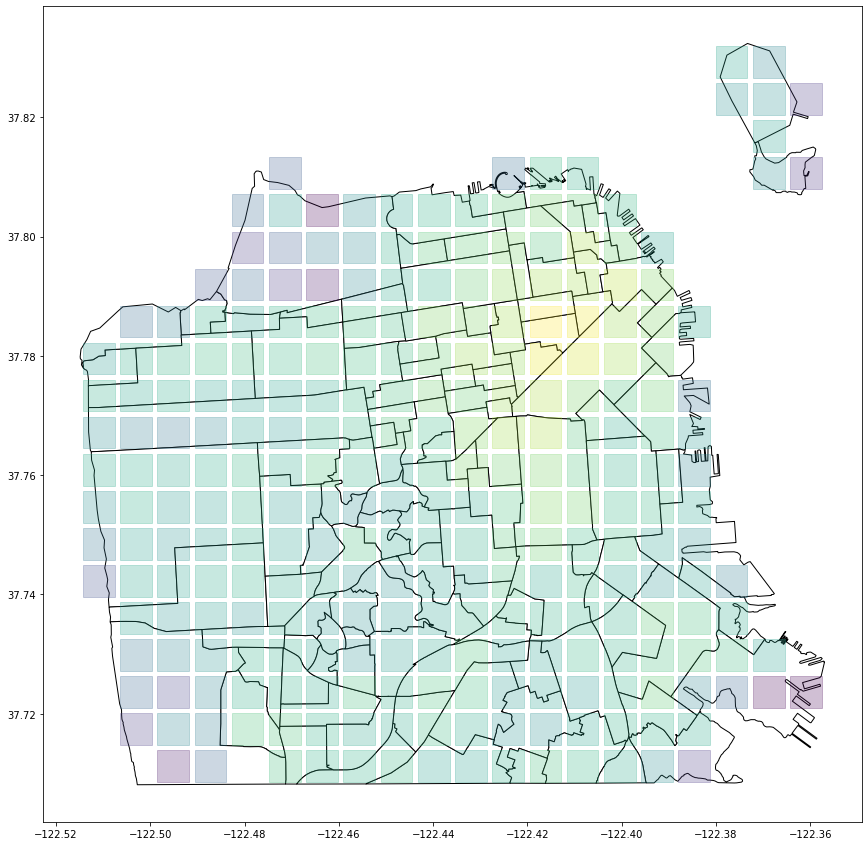

In [85]:
%matplotlib inline

incident_filter = pd.concat([freq.loc["TRUCK"].reset_index(), freq.loc["ENGINE"].reset_index()]).drop("incident_number", axis=1).drop_duplicates().reset_index(drop=True)

demand_data = unit_response_data.loc[unit_response_data.unit_type.eq("ENGINE") | unit_response_data.unit_type.eq("TRUCK")]
demand_data = demand_data.merge(incident_filter, how="inner", on="call_type")
demand_data = geo_pd.sjoin(demand_data, grid_zones, how="inner", op="within")

average_demand = demand_data.groupby('zone_idx').agg({"incident_number":"count"})
average_demand.rename({"incident_number":"incident_count"}, inplace=True, axis=1)
average_demand = grid_zones.merge(average_demand, on="zone_idx")

plt.rcParams["figure.figsize"]=15,15
full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = average_demand.centroid.plot(markersize=1000, marker="s", c = np.log(average_demand.incident_count.to_numpy()), ax=full_plot, alpha=0.25)


## Create final catchment areas

Skipping 51...
	# truck areas: 0
	# engine areas: 1
	# station: 0


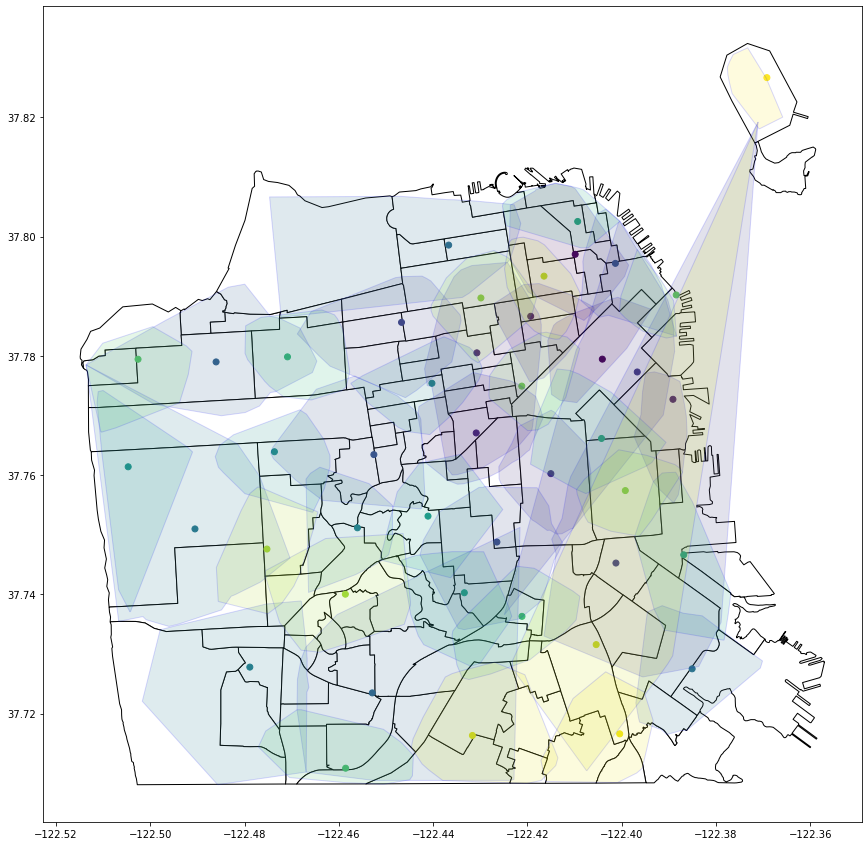

In [88]:
from shapely.ops import unary_union

unit_catchment_data = catchment_areas.unit_desc.str.split(" - ", expand=True).rename(columns={0:"unit_type", 1:"unit_code"})
fire_stations_name_col = unit_catchment_data.unit_code.str.extract("(\d+$)").rename(columns={0:"fire_station_number"})
unit_catchment_data = pd.concat([catchment_areas, unit_catchment_data, fire_stations_name_col], axis=1)
unit_catchment_data['fire_station_number'] = unit_catchment_data['fire_station_number'].astype('int64') 

truck_catchment_data = unit_catchment_data.loc[unit_catchment_data.unit_type.eq("TRUCK")]
engine_catchment_data = unit_catchment_data.loc[unit_catchment_data.unit_type.eq("ENGINE")]
fire_station_list = list(unit_catchment_data.fire_station_number.unique())

catchment_fire_station_name = []
catchment_fire_station_number = []
catchment_fire_station_areas = []
catchment_fire_station_location = []

fire_stations["fire_station_number"] = fire_stations.common_name.str.extract("#(\d+)")
fire_stations["fire_station_number"] = fire_stations["fire_station_number"].astype('int64')

for station in fire_station_list:
    truck_area = truck_catchment_data.loc[truck_catchment_data.fire_station_number.eq(station)]
    engine_area = engine_catchment_data.loc[engine_catchment_data.fire_station_number.eq(station)]
    curr_fire_station = fire_stations.loc[fire_stations.fire_station_number.eq(station)]
        
    if (truck_area.shape[0] == 1 or engine_area.shape[0] == 1) and (curr_fire_station.shape[0] == 1 or station == 7):
        catchment_fire_station_name.append(curr_fire_station.common_name.values[0])
        catchment_fire_station_number.append(station)

        if truck_area.shape[0] == 1:
            truck_area = truck_area.bounding_box.values[0]
        else:
            truck_area = engine_area.bounding_box.values[0]

        if engine_area.shape[0] == 1:
            engine_area = engine_area.bounding_box.values[0]
        else:
            engine_area = truck_area.bounding_box.values[0]

        catchment_fire_station_areas.append(unary_union([truck_area, engine_area]))
        catchment_fire_station_location.append(curr_fire_station.iloc[0].point)
    else:        
        print(f"Skipping {station}...")        
        print(f"\t# truck areas: {truck_area.shape[0]}")
        print(f"\t# engine areas: {engine_area.shape[0]}")
        print(f"\t# station: {curr_fire_station.shape[0]}")

final_catchments = geo_pd.GeoDataFrame({
    "common_name": catchment_fire_station_name,
    "fire_station_number":catchment_fire_station_number,
    "station_location": geo_pd.GeoSeries(catchment_fire_station_location, crs="EPSG:4326"),
    "catchment_area": geo_pd.GeoSeries(catchment_fire_station_areas, crs="EPSG:4326")
}, geometry="catchment_area", crs="EPSG:4326")

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = final_catchments.station_location.plot(cmap = "viridis", ax=full_plot)
_ = final_catchments.catchment_area.plot(cmap = "viridis", alpha=0.15, edgecolor="blue", ax=full_plot)

## Calculate Spatial Accessibility

In [125]:
# build a pivoted dataframe to use as a distance matrix
catchment_zones = geo_pd.sjoin(final_catchments, average_demand, how="inner", op="intersects")
catchment_zones = catchment_zones.loc[:, ['fire_station_number', 'zone_idx', 'incident_count']]
catchment_zones.set_index("zone_idx", inplace=True)
catchment_zones['dummy'] = 1
catchment_zones = catchment_zones.pivot(columns="fire_station_number", values='dummy')
catchment_zones.fillna(999, inplace=True)
catchment_zones.to_csv(data_dir_prefix + "/catchment_zone_dist.csv")

# lookup demand values for each row
demand_lookup = average_demand.set_index("zone_idx")
demand_values = []
for zone_idx in catchment_zones.index:
    demand_values.append(demand_lookup.loc[zone_idx].incident_count)

demand_values = np.array(demand_values)

# supply is just 1 per station
supply_values = np.ones(len(catchment_zones.columns))


In [133]:
from aceso.gravity import TwoStepFCA

fca = TwoStepFCA(1.5)
fca_output = fca.calculate_accessibility_scores(catchment_zones.to_numpy(), demand_values, supply_values)

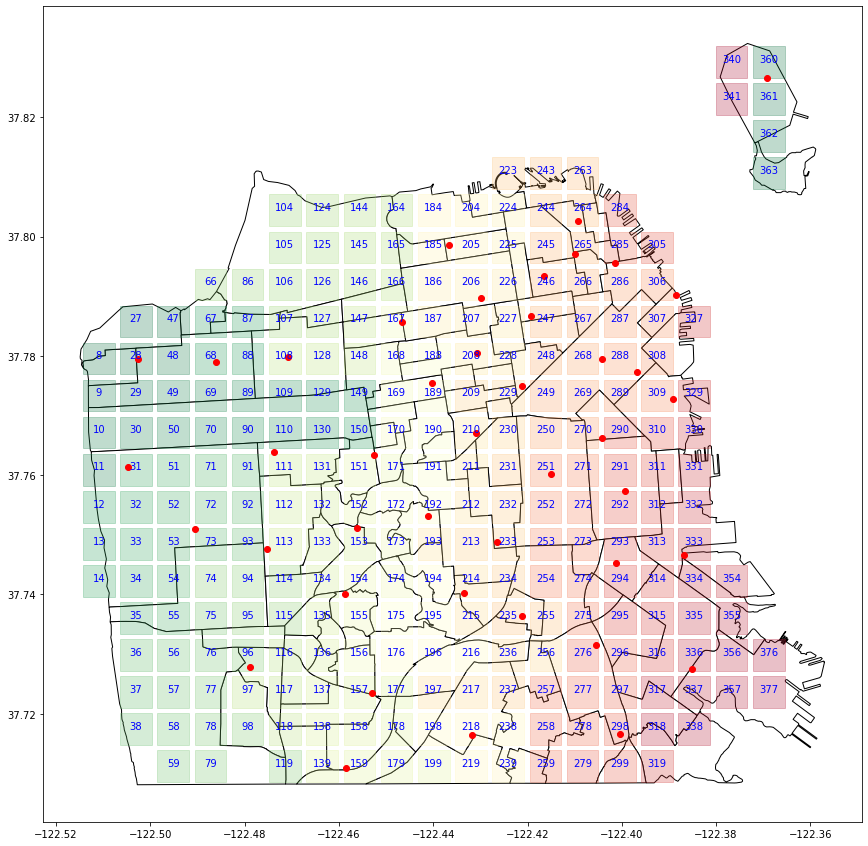

In [177]:
fca_output_df = pd.DataFrame({
    "zone_idx": pd.Series(catchment_zones.index),
    "accessibility_score": pd.Series(fca_output)
})
zone_output_df = average_demand.merge(fca_output_df, on="zone_idx", how="inner")

full_plot = sf_neighborhoods.plot(color="white", edgecolor="black")
_ = zone_output_df.centroid.plot(markersize=1000, marker="s", c = zone_output_df.accessibility_score.to_numpy(), cmap=plt.cm.RdYlGn.reversed(), ax=full_plot, alpha=0.25)

_= final_catchments.station_location.plot(color="red", ax=full_plot)

_ = zone_output_df.apply(
    lambda x: full_plot.annotate(
        text=str(x.zone_idx), 
        xy=x.centroid.coords[0], 
        color='blue', 
        ha='center', 
        size="10"), axis=1)


In [184]:
fca_output_df['scenario_name'] = 'baseline'
fca_output_df.to_csv(data_dir_prefix+'/raw/fca_output.csv')